In [1]:
%load_ext autoreload
%autoreload 2
    
import json
import string 
import re
import os
import multiprocessing as mp

import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle, resample

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import SGDClassifier

import gensim

from common import * 

In [2]:
nlp = spacy.load('en', disable=['ner'])

### Prepare dataset

In [3]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroups = [x for x in newsgroups.data]

In [6]:
data = pd.Series(newsgroups)
data = prepare_data(data)

In [7]:
train = [add_info(x) for x in data]
train = [window(x) for x in train]
train = [item for sublist in train for item in sublist]
train = [extract_features(x) for x in train] 

In [8]:
with open('../../../tasks/07-language-as-sequence/run-on-test.json') as f: 
    test = json.loads(f.read())
test = prepare_test(test)
test = [window(x) for x in test]
test = [item for sublist in test for item in sublist]
test = [extract_features(x) for x in test] 

In [9]:
with open('train.json', 'w') as f: 
    f.write(json.dumps(train))
with open('test.json', 'w') as f: 
    f.write(json.dumps(test))

### Load data

In [2]:
with open('train.json', 'r') as f: 
    train = json.loads(f.read())
with open('test.json', 'r') as f: 
    test = json.loads(f.read())

minority = [x for x in train if x['label'] == 1]
majority = [x for x in train if x['label'] == 0]

majority_down = resample(majority, replace=False, n_samples=len(minority), random_state=1234)

res = shuffle(minority + majority_down)

### Model without words

In [4]:
X = [{k:v for k, v in x.items() if k not in {'label', 'word+1', 'word-1', 'word-2', 'word'}} for x in res]
y = [x['label'] for x in res]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_val = [{k:v for k, v in x.items() if k not in {'label', 'word+1', 'word-1', 'word-2', 'word'}} for x in test]
y_val = [x['label'] for x in test]

In [6]:
vect = DictVectorizer(sparse=False)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [16]:
clf = RandomForestClassifier(criterion='entropy', n_estimators=200, n_jobs=-1)
clf.fit(X_train, np.array(y_train))
y_pred = clf.predict(X_test)
f1_score(np.array(y_test), y_pred)

0.8967680993185344

In [19]:
X_val = vect.transform(X_val)
y_val_pred = clf.predict(X_val)
f1_score(np.array(y_val), y_val_pred, average='macro')

0.6461022350477794

In [20]:
print(classification_report(y_val, y_val_pred))

             precision    recall  f1-score   support

          0       0.99      0.89      0.94      3944
          1       0.22      0.84      0.35       153

avg / total       0.96      0.89      0.92      4097



[[3503  441]
 [  25  128]]


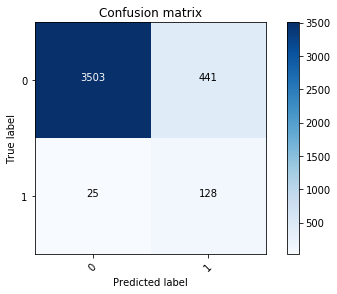

In [21]:
plot_confusion_matrix(confusion_matrix(y_val, y_val_pred), classes=[0, 1])

### word embeddings

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format('../../../../data/GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
X = [{k:v for k, v in x.items() if k not in {'label', 'word', 'word+1', 'word-1', 'word-2'}} for x in res]
y = [x['label'] for x in res]

X_words = [{k:v for k, v in x.items() if k in {'word', 'word+1', 'word-1', 'word-2'}} for x in res]
X_words = pd.DataFrame(X_words)

In [5]:
X_val = [{k:v for k, v in x.items() if k not in {'label', 'word', 'word+1', 'word-1', 'word-2'}} for x in test]
y_val = [x['label'] for x in test]

X_val_words = [{k:v for k, v in x.items() if k in {'word', 'word+1', 'word-1', 'word-2'}} for x in test]
X_val_words = pd.DataFrame(X_val_words)

In [6]:
def w2v(word): 
    try: 
        vec = model[word]
    except KeyError:
        vec = np.zeros(300)
    return vec

def get_features(df): 
    word = np.array(df['word'].apply(w2v).values.tolist())
    word_p1 = np.array(df['word+1'].apply(w2v).values.tolist())
    word_m1 = np.array(df['word-1'].apply(w2v).values.tolist())
    word_m2 = np.array(df['word-2'].apply(w2v).values.tolist())

    return np.concatenate([word, word_p1, word_m1, word_m2], axis=1)

In [7]:
X_words = get_features(X_words)
X_val_words = get_features(X_val_words)

vect = DictVectorizer(sparse=False)
X = vect.fit_transform(X)
X_val = vect.transform(X_val)

In [8]:
X_all = np.concatenate([X_words, X], axis=1)
X_all_val = np.concatenate([X_val_words, X_val], axis=1)

In [9]:
import lightgbm

clf = lightgbm.LGBMClassifier(boosting_type='gbdt', objective='binary', n_estimators=200) 
clf.fit(X_all, np.array(y))
y_pred = clf.predict(X_all_val)
f1_score(np.array(y_val), y_pred, average='macro')

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6820214310750589

In [10]:
print(classification_report(np.array(y_val), y_pred))

             precision    recall  f1-score   support

          0       0.99      0.91      0.95      3944
          1       0.27      0.86      0.41       153

avg / total       0.97      0.91      0.93      4097



[[3594  350]
 [  22  131]]


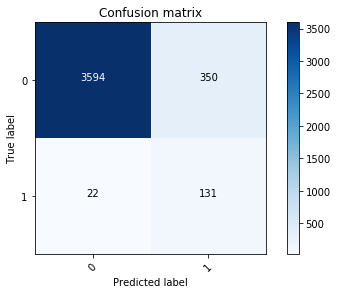

In [11]:
plot_confusion_matrix(confusion_matrix(np.array(y_val), y_pred), classes=[0, 1])